In [1]:
from superoscillations import *
import matplotlib.pyplot as plt

In [2]:
pulses = pd.read_excel('pulses.xlsx', dtype=np.float)

timecol = 'time (ps)'

# extract time colums and delet it
times = pulses[timecol].to_numpy()
pulses.drop(columns=[timecol], inplace=True)

pulses = pulses[
    ['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz']
]

pulses.columns

Index(['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz'], dtype='object')

In [3]:
so = CTSuperoscillations(pulses, times)

In [4]:
so.largest_freq

'f=0.8 THz'

Calculate the overlap matrix
$$
 S_{ij}(-\infty, \infty) = \int_{-\infty}^{\infty} E_i(t) E_j(t) dt
$$

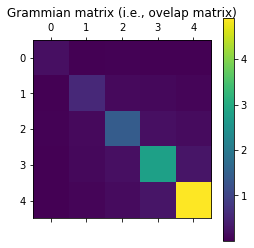

In [5]:
plt.matshow(np.abs(so.S_infty))
plt.colorbar()
plt.title("Grammian matrix (i.e., ovelap matrix)")
plt.show()

In [6]:
def plot_pulses(df):
    """
    Plot pulses saved in DataFrame dt
    """
    for colname in df.columns:        
        
        plt.plot(times, df[colname], label=colname)

    plt.ylabel('Nomrlized electric field')
    plt.xlabel(timecol)
    plt.legend(loc='right')

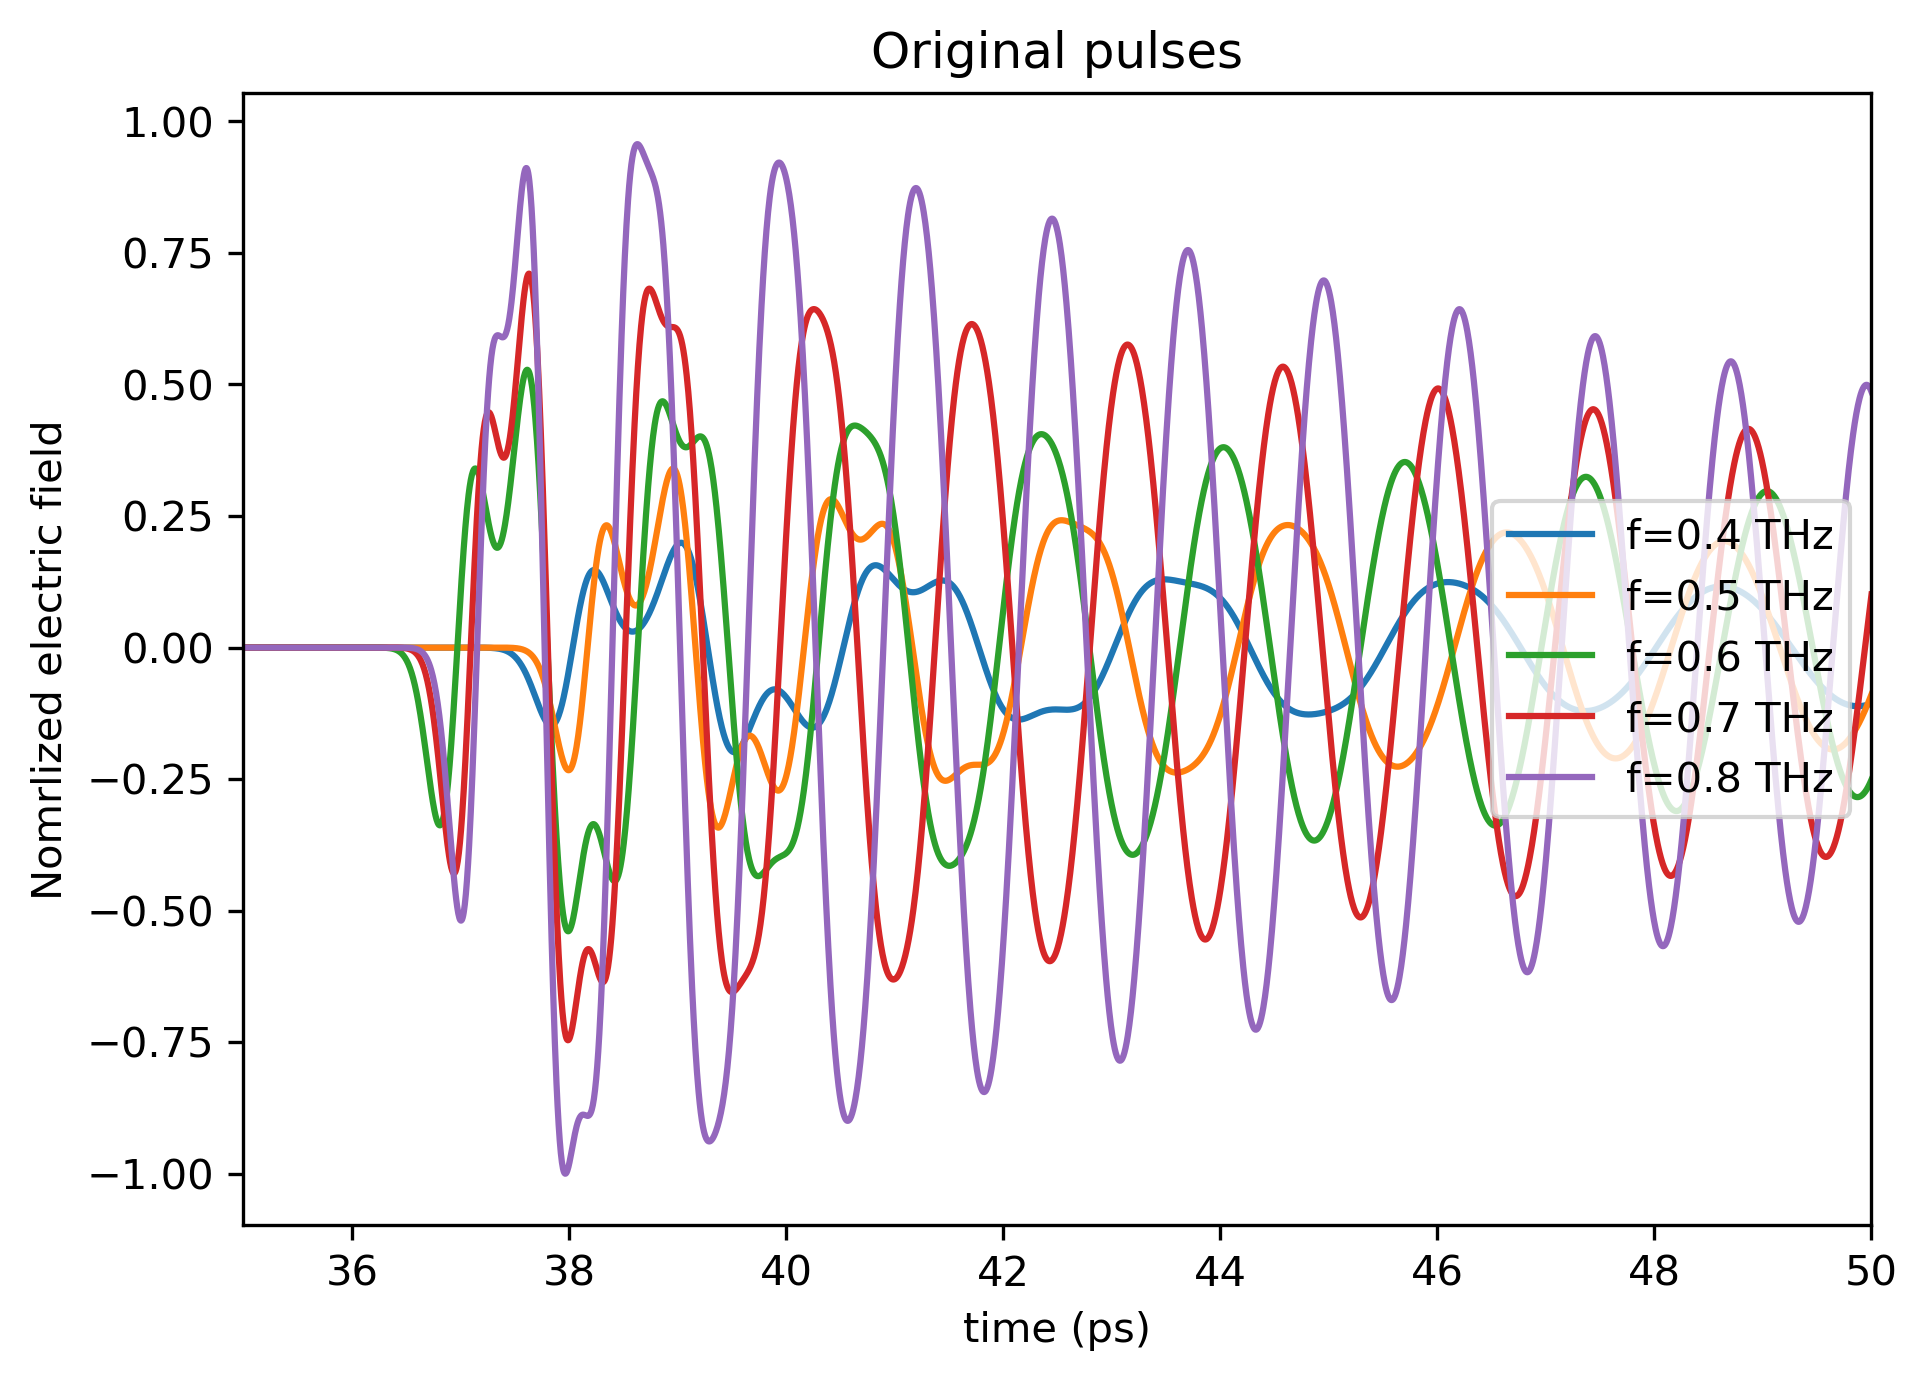

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 50])
plt.title('Original pulses')
plot_pulses(so.pulses)
plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

In [8]:
so.time_align_pulses()

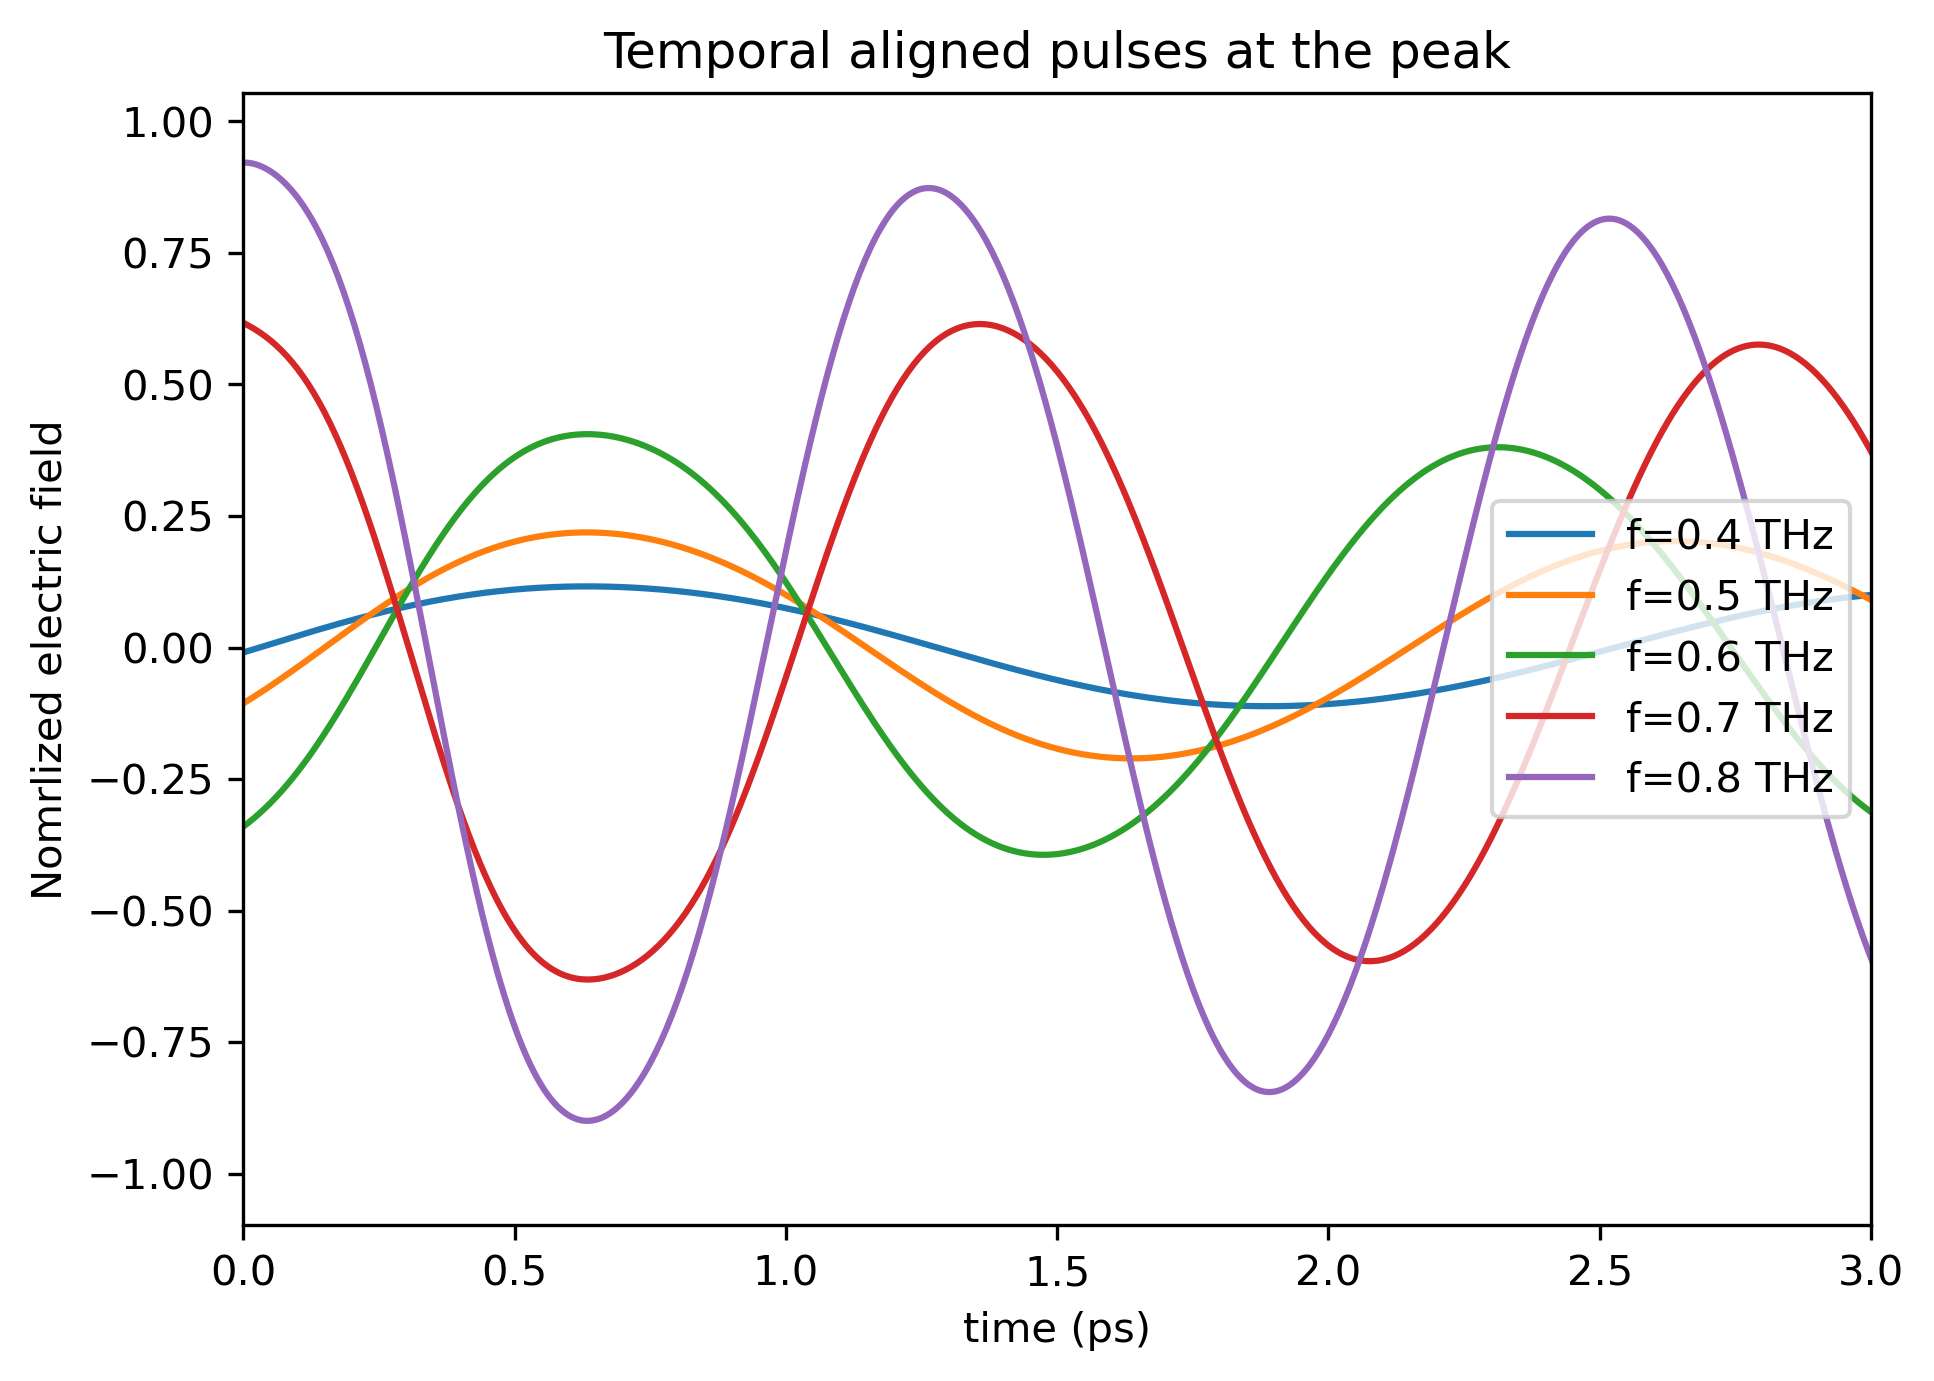

In [9]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([0, 3])
plt.title('Temporal aligned pulses at the peak')
plot_pulses(pulses)
plt.savefig("alighned_pulses.pdf", transparent=True)
plt.show()

Calculate the overlap matrix for the observational window
$$
    S_{ij}(0, T_0) = \int_{0}^{T_0} E_i(t) E_j(t) dt
$$

In [10]:
observational_window = so.observational_window

S_observ = get_overlap(
    so.pulses[:observational_window], 
    so.times[:observational_window]
)

In [11]:
# Finding optimal strategies for generating supperoscilations via eigenvectors
vals, vecs = eigh(S_observ, so.S_infty)

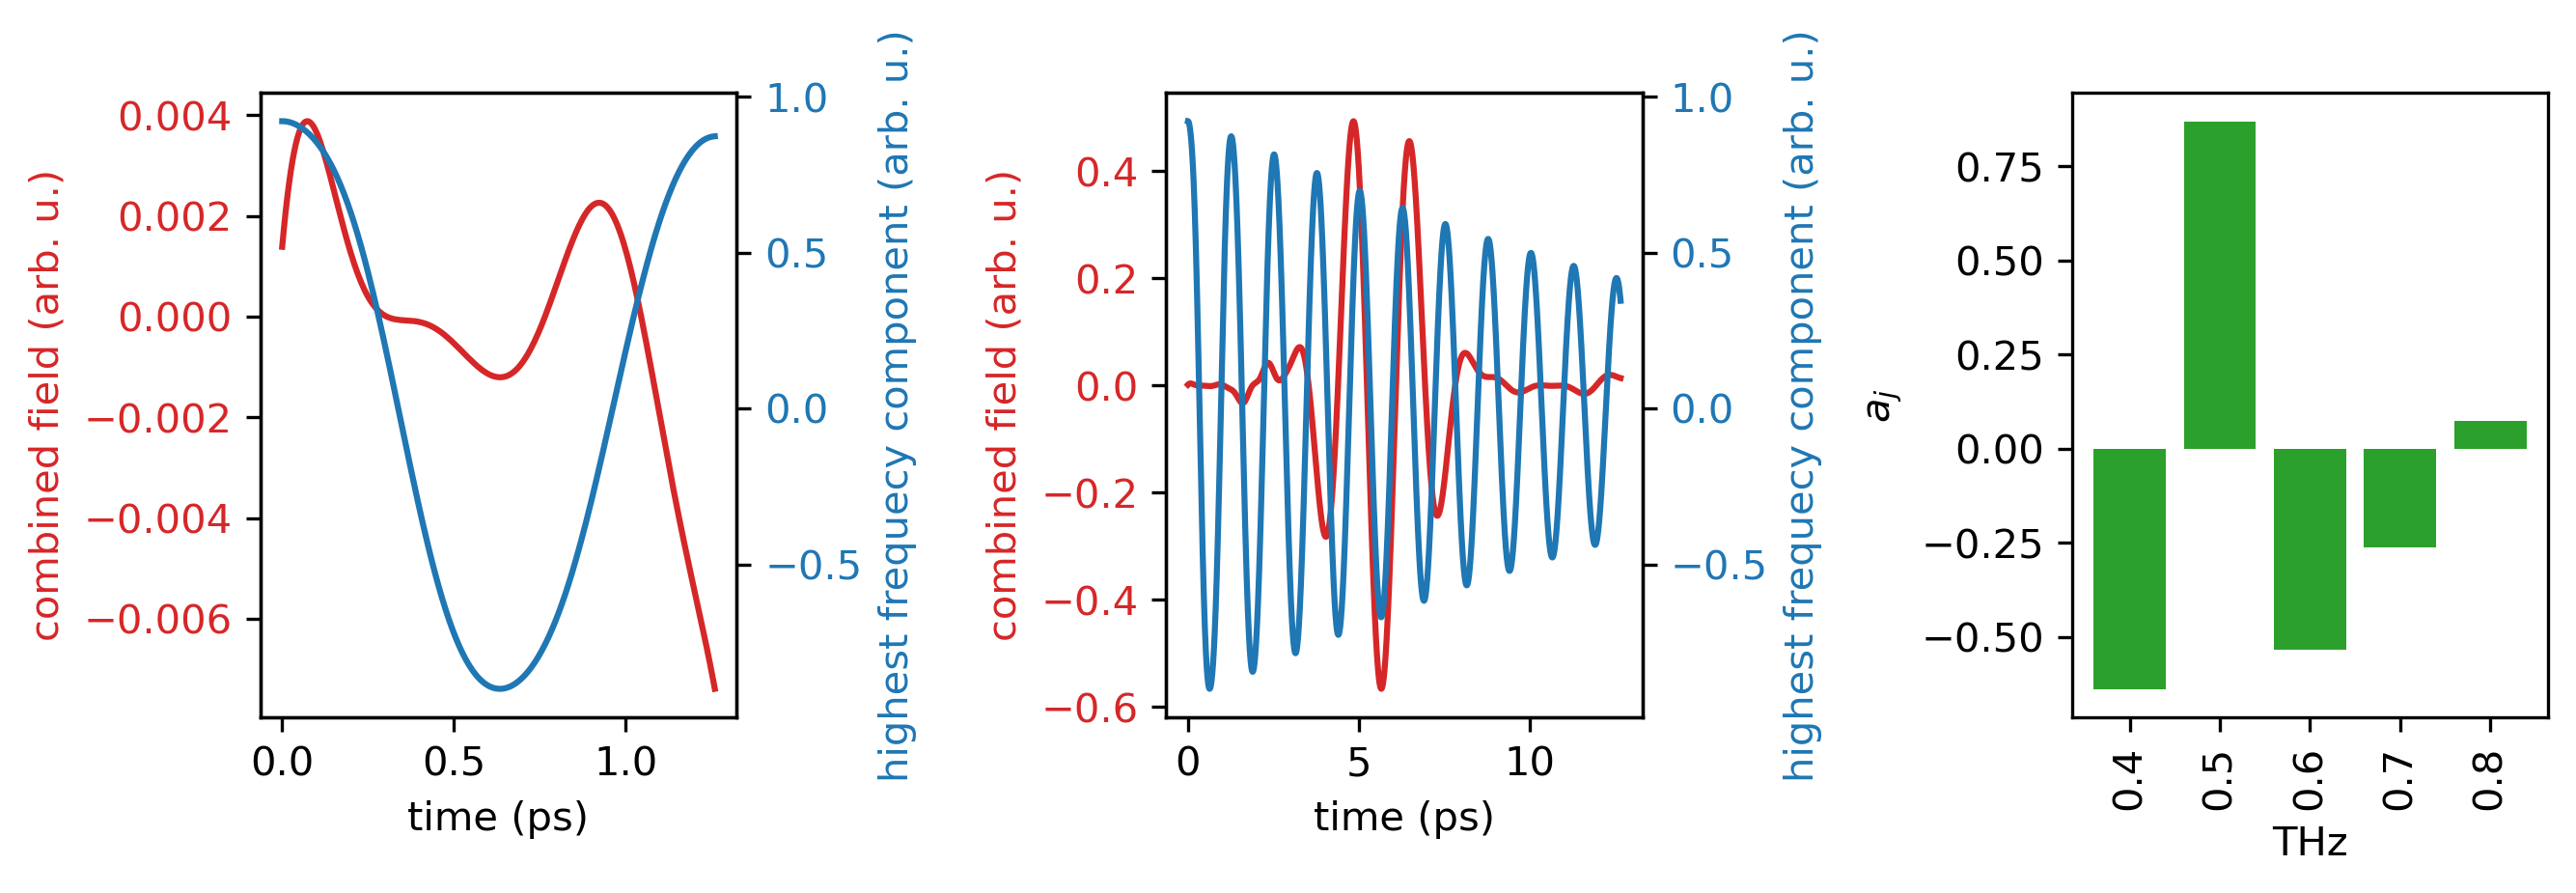

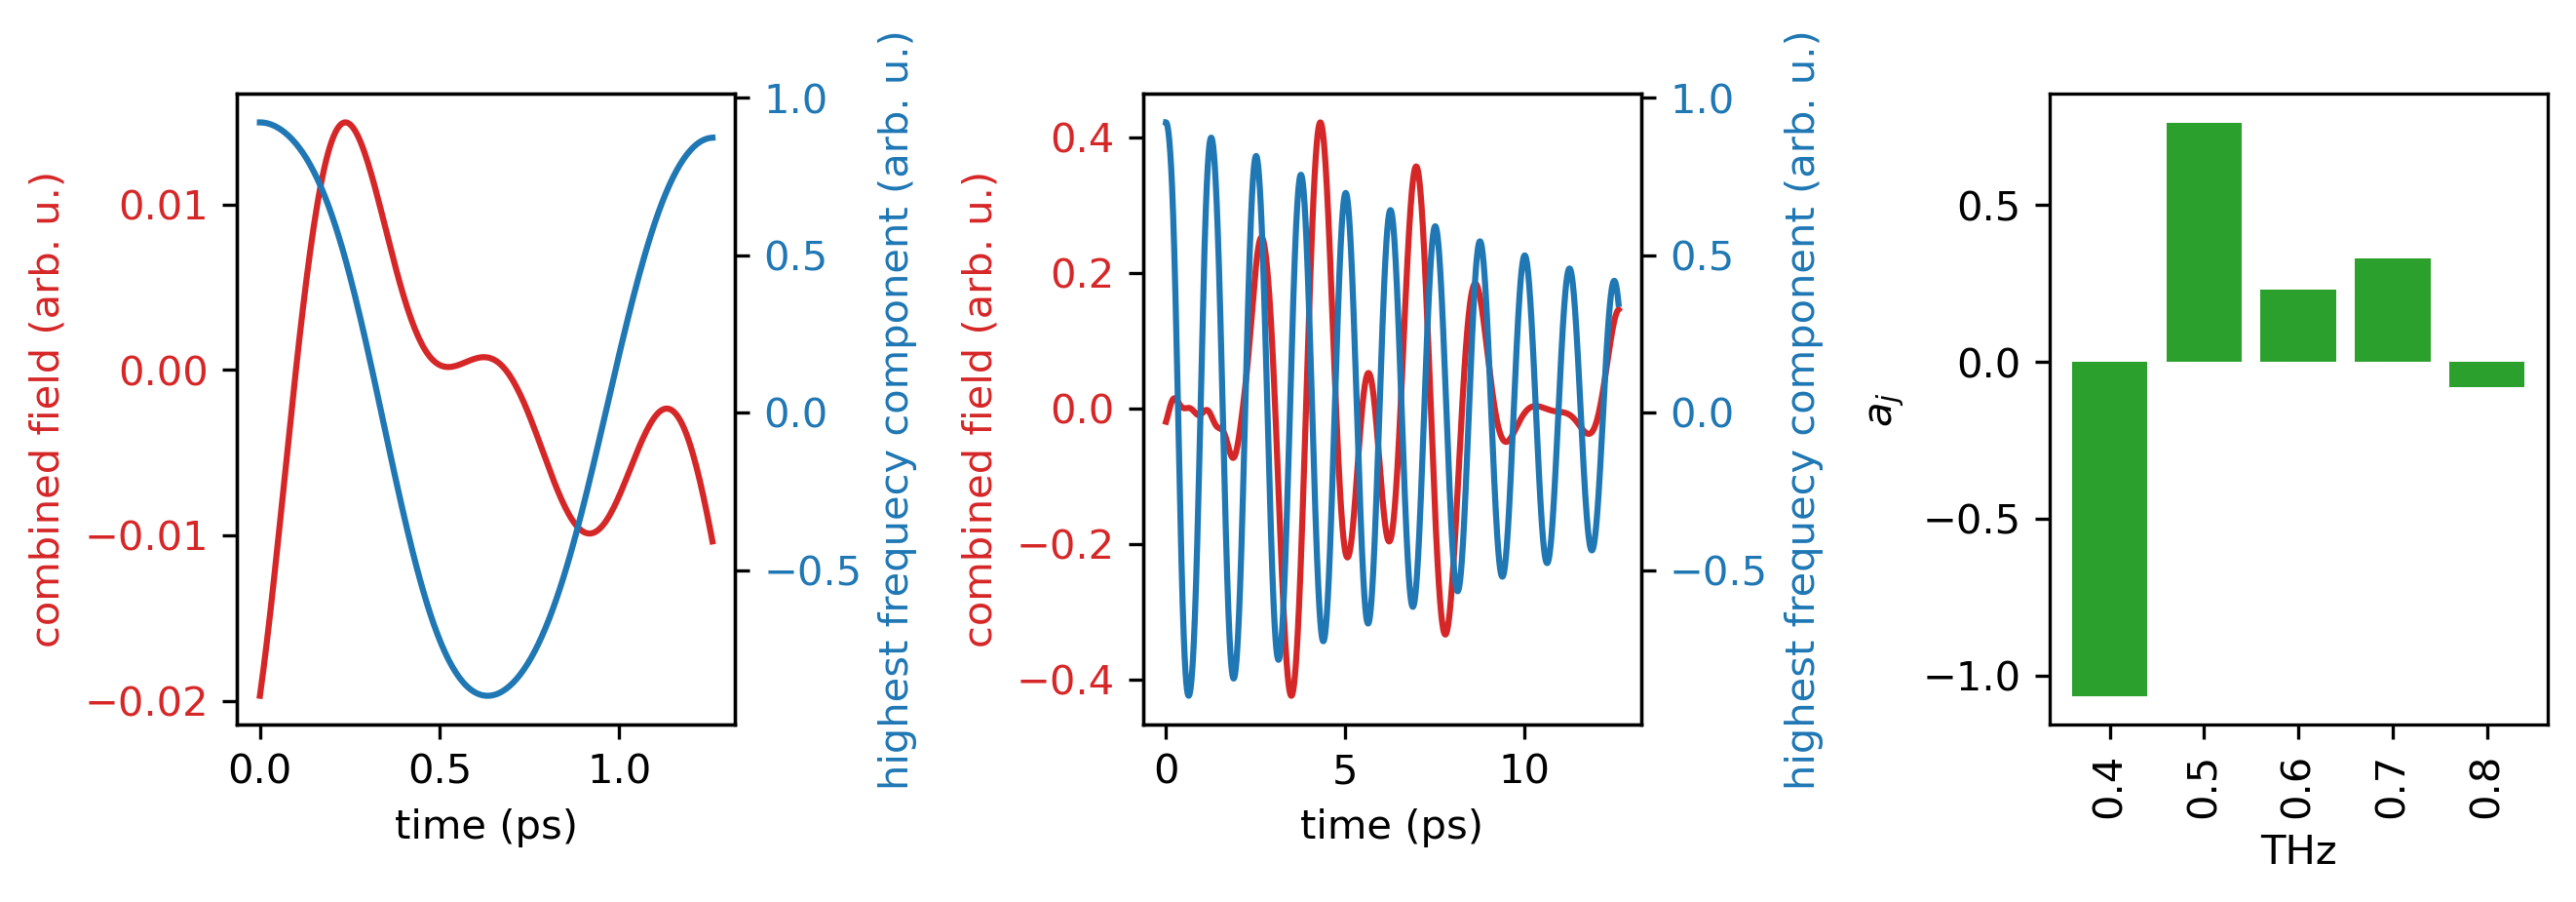

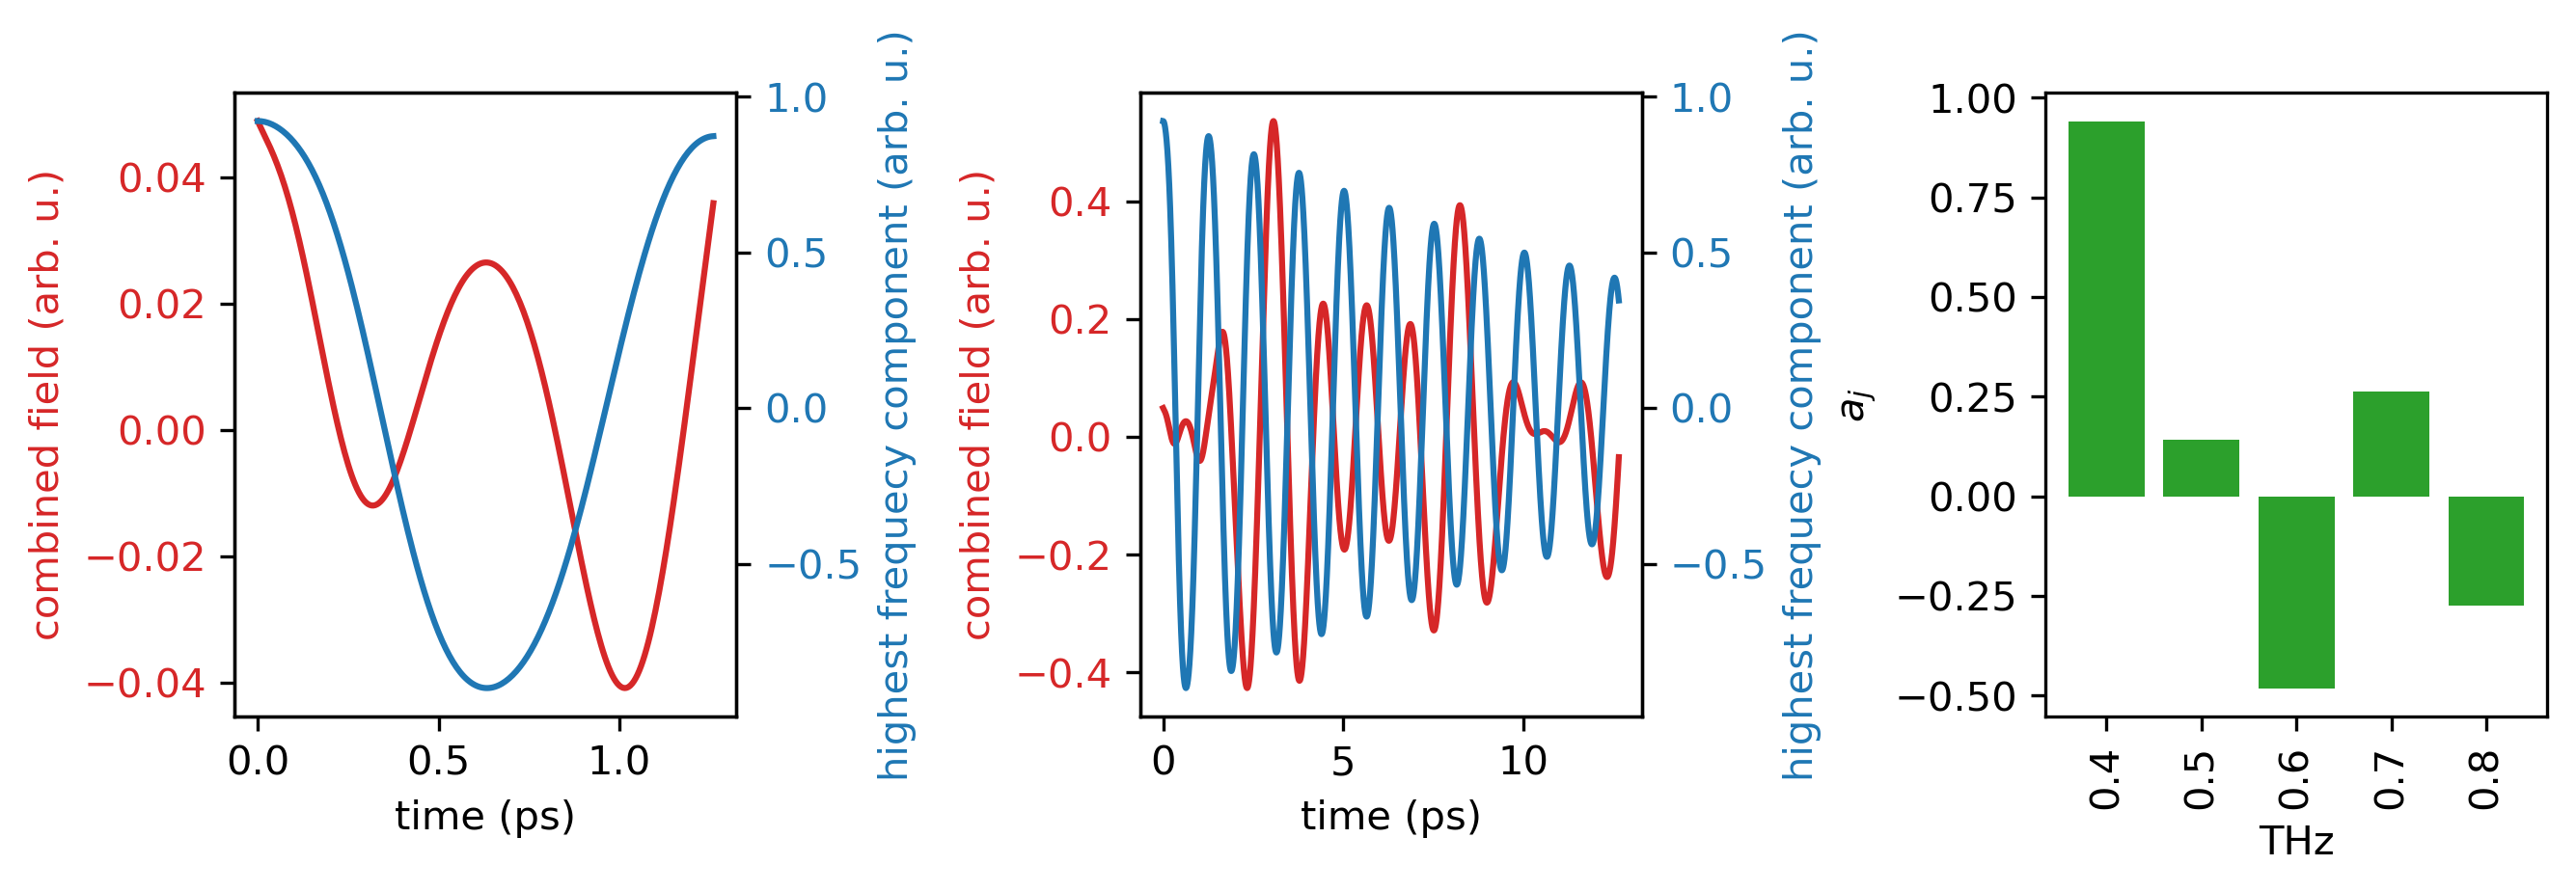

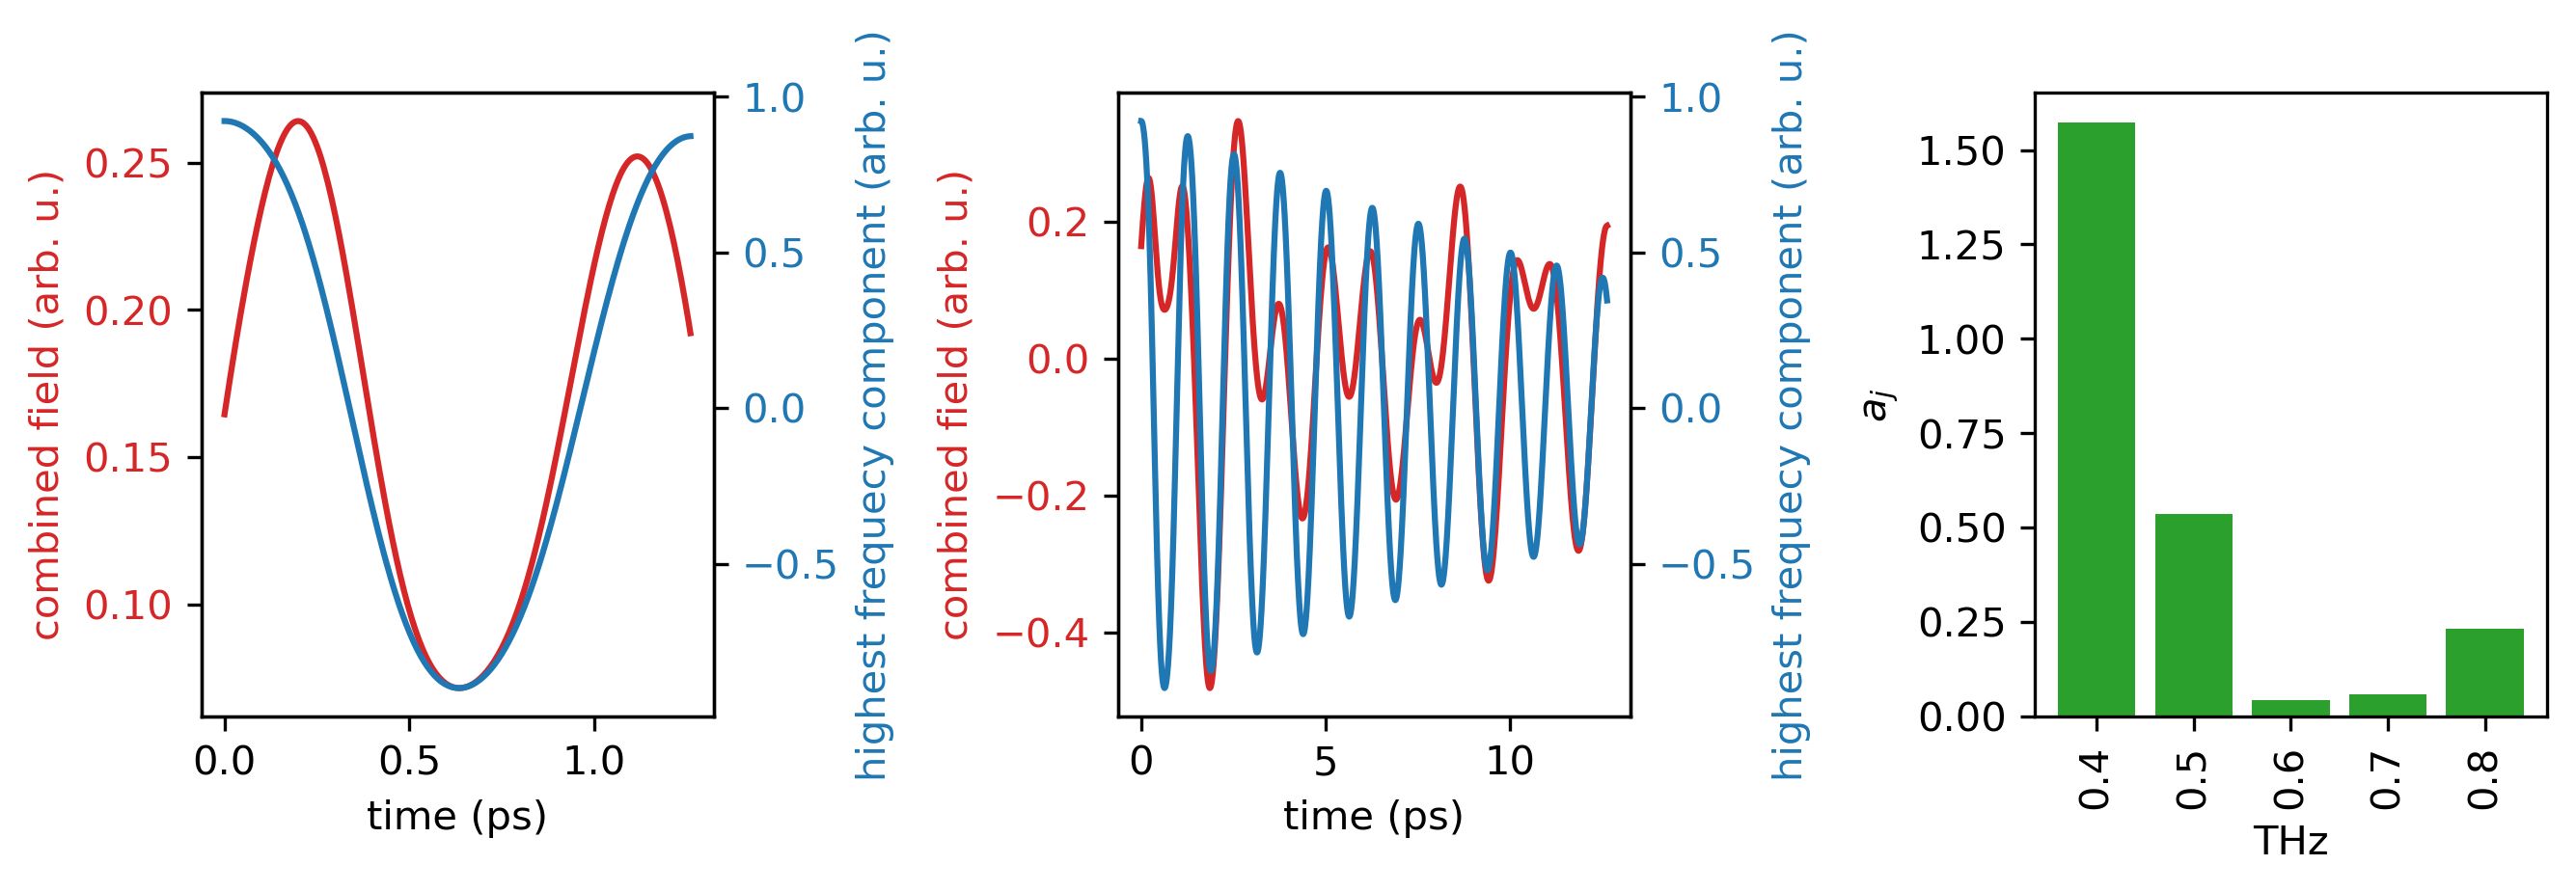

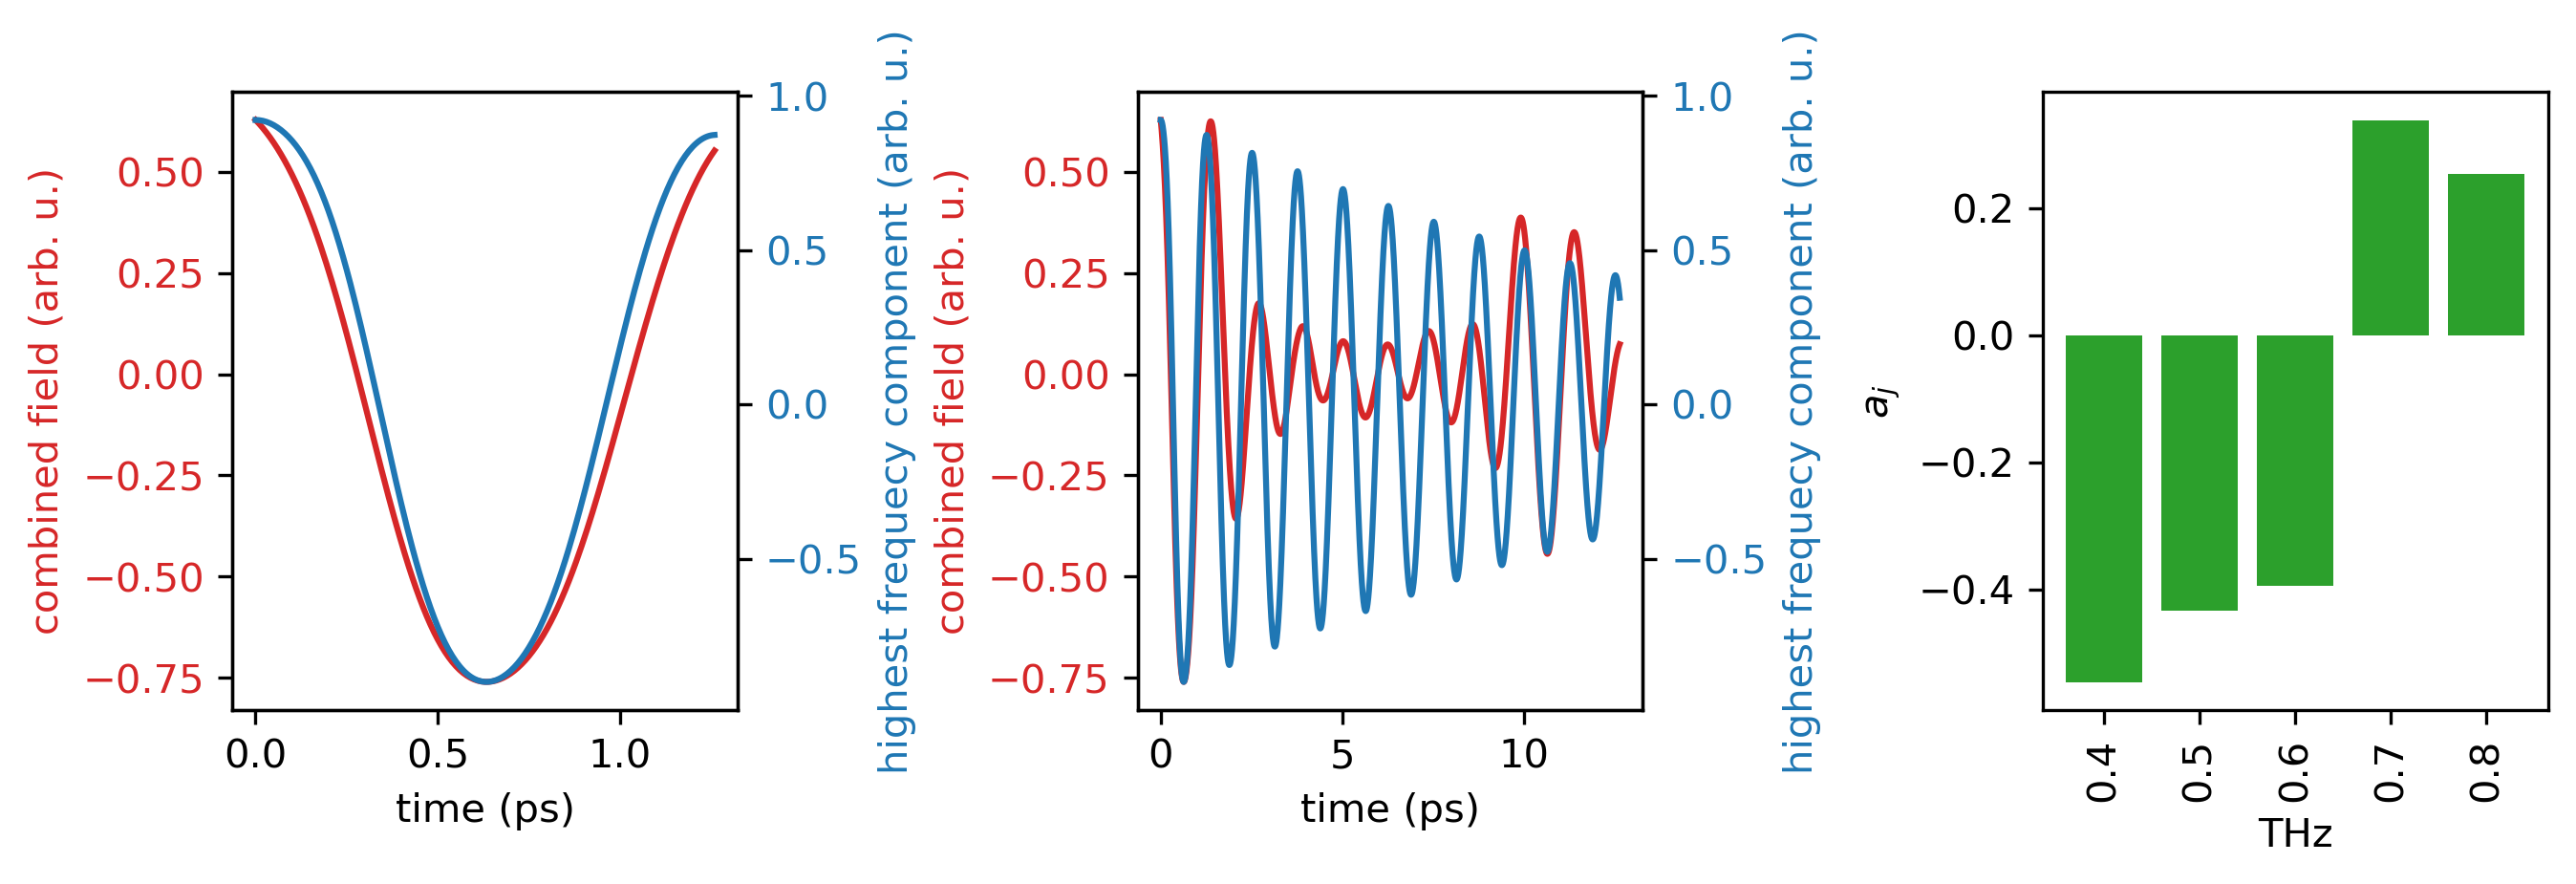

In [12]:
largest_freq_pulse = so.pulses[so.largest_freq]
omega = so.omega

for num, eig_vector in enumerate(vecs.T):
    
    # get superoscilating fields
    field = pulses @ eig_vector
    
    # a sanity check
    assert np.allclose(eig_vector.T @ so.S_infty @ eig_vector, 1.)
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:observational_window], field[:observational_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:observational_window], largest_freq_pulse[:observational_window], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot zoom out view
    larger_window = 10 * observational_window
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:larger_window], field[:larger_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:larger_window], largest_freq_pulse[:larger_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(omega, rotation='vertical')
    ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.pdf'.format(num), transparent=True)
    
    plt.show()